In [1]:
%matplotlib inline

In [2]:
def check_quantity_has_only_one_element(list_of_quant):
    values = []
    for val, name in list_of_quant:
        try:
            if len(val) > 1:
                msg = "{0} must be a scalar quantity or an 1-element array.\n"\
                "Found = {1} instead".format(name, val)
            v = val[0]
        except TypeError:
            # scalar quantity has no len
            v = val
            pass
        
        values.append(v)
       
    return values
        

In [9]:
def download_web_talks_for_year(year):
    import datetime
    import requests
    try:
        from bs4 import BeautifulSoup
    except ImportError:
        from BeautifulSoup import BeautifulSoup
    
    # Need to pass a list of tuples; the first element is the
    # value itself, while the second is the human-understandable 
    # name of the variable
    year = check_quantity_has_only_one_element([(year, "year")])
    year = year[0]
            
    now = datetime.datetime.now()
    current_year = now.year
    min_year = 2000 # CAS only has records going back to 2000
    if year > current_year or year < min_year:
        msg = "Year = {0} should be within [{1}, {2}]".format(year, min_year, current_year)
        raise ValueError(msg)
    if year <= 2010:
        url = "http://astronomy.swin.edu.au/research/colloquia_{0}.html".format(year)
    else:
        url = "http://astronomy.swin.edu.au/research/colloquia.php?year={0}".format(year)
    r = requests.get(url)
    if r.status_code != 200:
        msg = "Encountered error while fetching webpage {0}".format(url)
        raise RuntimeError(msg)
    
    c = r.content
    soup = BeautifulSoup(c, "lxml")

    # search for individual talk entries
    talks = soup.findAll(["div"], {"class":["talk"]})
    
    return talks        

In [10]:
def parse_talks_for_year(year, 
                         requested_talk_type="Colloquium", 
                         text_type="abstract",
                         save_image=False, **wc_kwargs):
    
    from wordcloud import WordCloud
    check_quantity_has_only_one_element([(requested_talk_type, "requested talk type"),
                                         (text_type, "text section to parse"),
                                        ])
    
    valid_talk_types = ["Colloquium"]
    if not requested_talk_type in valid_talk_types:
        msg = "Please request talks of one of these types = {0}"\
               .format(valid_talk_types)
        raise ValueError(msg)
        
    valid_text_types = ["abstract", "title"]
    if not text_type in valid_text_types:
        msg = "Please request the text from these following sections = {0}"\
               .format(valid_text_types)
        raise ValueError(msg)
    
    talks = download_web_talks_for_year(year)
    ntalks = len(talks)
    if ntalks == 0:
        return None
    
    all_text_content = ""
    talks_of_correct_type = 0
    for talk in talks:
        if year >= 2011:
            talk_type = talk.find(["span"], {"class":["title"]})
            if not requested_talk_type.upper() in talk_type.text.upper():
                continue
        
        talks_of_correct_type += 1

        text_content = talk.find(["div", "span"], {"class":[text_type]})
        
        # there was no abstract field for this talk
        if text_content is None:
            continue

        # extract the text for the abstract
        text_content = text_content.text

        # short text in the content (abstract, talk title) are 
        # probably a sign that no relevant text was supplied/found
        if len(text_content) <= 50:
            continue

        if "TBC" in text_content or "TBA" in text_content:
            print("Found TBC or TBA in the {0} text field".format(text_type))
            continue
            
        all_text_content = "\n".join([all_text_content, text_content])
        
    print("Found {0} {1} talks (out of a total of {2} talks) for year {3}".
          format(talks_of_correct_type, requested_talk_type, ntalks, year))
    if len(all_text_content) == 0:
        return None
    
    # replace galaxy with galaxies
    all_text_content = all_text_content.replace("galaxy", "galaxies")
    all_text_content = all_text_content.replace("Galaxy", "galaxies")
    wordcloud = WordCloud(**wc_kwargs).generate(all_text_content)
    
    if save_image:
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12,12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        fig.savefig("{0}-{1}-{2}-spiralgalaxy.png".format(requested_talk_type, text_type, year))
        plt.close()
        
        
    return wordcloud, all_text_content

In [11]:
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("will")
stopwords.add("results")
stopwords.add("observations")
stopwords.add("abstract")
stopwords.add("discuss")  
stopwords.add("provide")
stopwords.add("use")
stopwords.add("show")
stopwords.add("based")
stopwords.add("us")
stopwords.add("using")
stopwords.add("used")
stopwords.add("now")
stopwords.add("within")
stopwords.add("Colloquium")
stopwords.add("still")

width = 1600
height = 1200

In [33]:
import wordcloud
from wordcloud import STOPWORDS

from PIL import Image
from os import path
import numpy as np
import matplotlib.pyplot as plt

d = path.dirname(wordcloud.__file__)
mask = np.array(Image.open(path.join(d, "examples", "alice_mask.png")))
galaxy_image = "ngc1232b_vlt_960.jpg"
galaxy_image = "m51-hires.jpg"
#galaxy_image = "1024px-Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg"
#galaxy_image = "1280px-M101_hires_STScI-PRC2006-10a.jpg"
#galaxy_image = "barred-spiral-galaxy-ngc-1300-chris-butler.jpg"
#galaxy_image = "AntennaePellicciaOlsen_mark.jpg"
#galaxy_image = "000029.jpg" # pic of a cat (https://automatetheboringstuff.com/images/)
#galaxy_image = "most-popular-cats-grumpy-cat-4.jpg"
#galaxy_image = "HubbleTuningFork2w.jpg"
#galaxy_image = "HSTtuningfork.png"
#galaxy_image = "2-astronomerss.jpg"
galaxy_image = "DYERG6aXkAIPjGK.jpg" # taken from an ASTRO3D retweet
galaxy_image = "26051648667_9ec89747fa_o.png" #https://www.flickr.com/photos/geckzilla/26051648667/
thresh = 120 # 60 works well for the antennae image
image = np.array(Image.open(galaxy_image))
mask = image.sum(axis=2)
mask[mask < thresh] = 255 #for the 00029.jpg cat photo, > is required, everything else requires the " < "

parse_talks_for_year(2017, save_image=True, background_color="white", mask=mask,
                     width=width, height=height, text_type="abstract",
                     stopwords=stopwords, max_words=2000);
plt.close()

Found 33 Colloquium talks (out of a total of 52 talks) for year 2017


In [34]:
years = [2000 + y for y in range(19)]

In [35]:
import operator
all_text_types = []
all_wordclouds = []
top_N = 10
for text_type in ["abstract", "title"]:
    all_text_content = ""
    for y in years:
        wordcloud, annual_text = parse_talks_for_year(y, save_image=True, background_color="white", 
                                                      width=width, height=height, text_type=text_type,
                                                      stopwords=stopwords, relative_scaling=0.0)
        all_text_content = "\n".join([all_text_content, annual_text])
        all_wordclouds.append(wordcloud)
    
        annual_words_dict = wordcloud.words_
        sorted_x = sorted(annual_words_dict.items(), key=operator.itemgetter(1), reverse=True)
        how_many = top_N if len(sorted_x) > top_N else len(sorted_N)
        print("For year: {0}, top {1} words in the {2} were: ".format(y, how_many, text_type))
        string_lengths = [len(w) for (w, _) in sorted_x[0:how_many]]
        total_length = sum(string_lengths) + 2 + how_many
    
        print("-" * total_length)
        for w, _ in sorted_x[0:how_many]:
            print("{0} ".format(w), end="")
        
        print("\n" + "-" * total_length + "\n")
        
    all_text_types.append((text_type, all_text_content))

Found 4 Colloquium talks (out of a total of 4 talks) for year 2000
For year: 2000, top 10 words in the abstract were: 
------------------------------------------------------------
galaxies Dwarf halo quasar colour LSB survey star low CDM 
------------------------------------------------------------

Found 24 Colloquium talks (out of a total of 24 talks) for year 2001
For year: 2001, top 10 words in the abstract were: 
---------------------------------------------------------------------
galaxies HI redshift high formation halo evolution data solar star 
---------------------------------------------------------------------

Found 24 Colloquium talks (out of a total of 24 talks) for year 2002
For year: 2002, top 10 words in the abstract were: 
-------------------------------------------------------------------------------
galaxies structure star emission formation Space type survey region Galactic 
-------------------------------------------------------------------------------

Found 29 

Found 36 Colloquium talks (out of a total of 36 talks) for year 2005
For year: 2005, top 10 words in the title were: 
---------------------------------------------------------------------------------
galaxies clusters High Evolution Redshift Dwarf Survey Local star Interstellar 
---------------------------------------------------------------------------------

Found 46 Colloquium talks (out of a total of 46 talks) for year 2006
For year: 2006, top 10 words in the title were: 
------------------------------------------------------------------------------------
galaxies Star Evolution Neutron Cluster black holes Structure Double Interstellar 
------------------------------------------------------------------------------------

Found 47 Colloquium talks (out of a total of 47 talks) for year 2007
For year: 2007, top 10 words in the title were: 
---------------------------------------------------------------------------------------------
galaxies Stellar Dark Populations Galactic Universe G

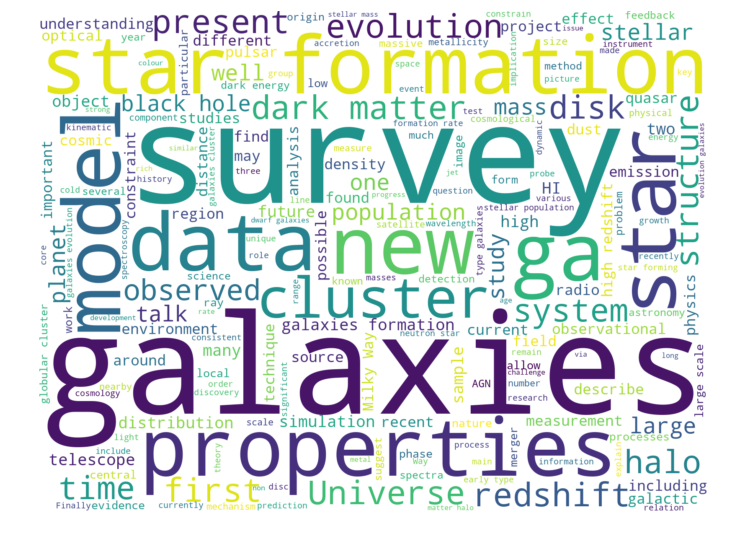

In [37]:
from wordcloud import WordCloud
_, all_abstracts = all_text_types[0]
cumulative_wordcloud = WordCloud(background_color="white", 
                                 width=width, height=height, 
                                 stopwords=stopwords, relative_scaling=0.0).generate(all_abstracts)
    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.imshow(cumulative_wordcloud, interpolation='bilinear')
plt.axis("off")
fig.savefig("CAS-through-years-{}-{}.png".format(min(years), max(years)))